#DERS 19- ADABOOST 

Rastgele binlerce kişiye karmaşık bir soru sorduğunuzu varsayalım ve cevaplarını toplayalım. Çoğu zaman, bu toplu cevabın bir uzmanın cevabından daha iyi olduğunu göreceksiniz.Benzer şekilde, bir grubun tahminlerini (sınıflayıcılar veya regresörler gibi) toplarsanız, genellikle en iyi bireyselden daha iyi tahminler alırsınız.Bir grup şeklinde olan tahmin algoritmalarına ensemble denir; bu nedenle, bu tekniğe Ensemble Learning denir ve bir Ensemble Learning algoritmasına Ensemble yöntemi denir.

Adaboost
Yeni bir predictor(tahminci) bir önceki tahmini düzeltmesinin bir yolu, bir önceki tahminin uyguladığı eğitim durumlarına biraz daha dikkat etmektir. Bu, zor durumlara giderek daha fazla odaklanan yeni tahminlerle sonuçlanır. AdaBoost tarafından kullanılan teknik budur. Örneğin, bir AdaBoost sınıflandırıcısı oluşturmak için, birinci temel sınıflandırıcı eğitilir ve eğitim seti hakkında tahminlerde bulunmak için kullanılır. Yanlış sınıflandırılmış eğitim durumlarının nispi ağırlığı artırılır ve bizim için daha değerli hale gelir. İkinci bir sınıflandırıcı, güncellenmiş ağırlıklar kullanılarak eğitilir ve yine antrenman setinde tahminler yapar, ağırlıklar güncellenir bu özellik son aşamaya kadar tekrar edilir.

Tüm modeller eğitildikten sonra, ensemble tahmin yapmayı, bagging veya pastinge benzer şekilde yapar, ancak modeller, ağırlıklı eğitim setindeki genel doğruluklarına bağlı olarak farklı ağırlıklara sahiptir.

Not: Bu sıralı öğrenme tekniğinin önemli bir dezavantajı vardır: Paralelleştirilemez , çünkü her tahminci yalnızca önceki modele göre eğitilip değerlendirildikten sonra eğitilebilir. Sonuç olarak, bagging veya pasting gibi ölçeklenmez.(Şeekiller) 

Detaylı Okuma: https://medium.com/@oguzkircicek/ensemble-learning-7ec8c9a7227f

Bu çalışmada, meme kanseri veri setini inceleyecek ve kişinin meme kanseri olup olmadığını tahmin etmek için modeli eğitmeye çalışacağız. Weak learner kullanacağız yani maksimum derinliği =2 olan bir karar ağacı diyebiliriz.

Daha sonra weak learner'ları 3'er 3'er arttırarak en iyi modeli bulmaya çalışacağız.

Kütüphaneleri yükleyerek başlayalım.

In [ ]:
import numpy as np 
import pandas as pd 
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_digits
from sklearn import metrics
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')


Meme kanseri veri setini kullanarak kişinin kanser olup olmadığını bulmaya çalışacağız. Bağımlı değişkenimiz target.
Aşağıdaki veri setindeki bağımsız değişkenlere baktığımızda anlayabilmek için bir doktor olmamız gerekebilirdi.
Ancak makine öğrenmesinde veriler ile iş yaptığımızdan bu işin uzmanı olmamıza gerek yok. Gerekli örüntüyü yakalayıp modeli
kurduğumuzda başarılı sonuçlar elde edebiliriz.

In [ ]:
cancer = load_breast_cancer() # verinin yüklenmesi
digits = load_digits()

data = cancer

In [ ]:
df = pd.DataFrame(data= np.c_[data['data'], data['target']],
                     columns= list(data['feature_names']) + ['target'])
df['target'] = df['target'].astype('uint16') # bağımlı değişkenin veri tipinin belirlenmesi

In [ ]:
df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


In [ ]:
df.head() #verinin ilk 5 satırı

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [ ]:
# bağımsız ve bağımlı değişkenlerin birbirinden ayırılması
X = df.drop('target', axis=1)
y = df[['target']]

# verinin train ve test set'lere bölünmesi.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(455, 30)
(455, 1)
(114, 30)
(114, 1)


In [ ]:
# train ve test set'lerdeki bağımlı değişkenin benzer şekilde dağılıp dağılmadığının kontrol edilmesi.
print(y_train.mean())
print(y_test.mean())

target    0.626374
dtype: float64
target    0.631579
dtype: float64


In [ ]:
# Adaboost'ta derinliği olmayan ufak karar ağaçları kullanıyorduk. Maksimum kırılımı 2 olan karar ağacı oluşturalım.
shallow_tree = DecisionTreeClassifier(max_depth=2, random_state = 100)

In [ ]:
# modeli öğrenelim.
shallow_tree.fit(X_train, y_train)

# test hatalarının ekrana bastırılması.
y_pred = shallow_tree.predict(X_test)
score = metrics.accuracy_score(y_test, y_pred)
score

0.9385964912280702

Şimdi de adaboost'ta 1'den 50'ye kadar 3'er 3'er artacak şekilde farklı sayılarda weak learner ile sınıflama yapalım.

In [ ]:
# olası ağaç sayılarını tutacak olan listenin oluşturulması.

estimators = list(range(1, 50, 3))

abc_scores = []
for n_est in estimators:
    ABC = AdaBoostClassifier(
    base_estimator=shallow_tree, 
    n_estimators = n_est)
    
    ABC.fit(X_train, y_train)
    y_pred = ABC.predict(X_test)
    score = metrics.accuracy_score(y_test, y_pred)
    abc_scores.append(score)
    

In [ ]:
abc_scores # Farklı adaboost modellerinin tutarlılık sonuçları.

[0.9473684210526315,
 0.9298245614035088,
 0.9473684210526315,
 0.9736842105263158,
 0.9649122807017544,
 0.956140350877193,
 0.9649122807017544,
 0.9649122807017544,
 0.956140350877193,
 0.956140350877193,
 0.9649122807017544,
 0.9824561403508771,
 0.9649122807017544,
 0.9736842105263158,
 0.9649122807017544,
 0.9824561403508771,
 0.9824561403508771]

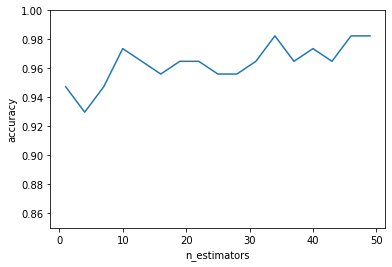

In [ ]:
# test accuracy'lerinin plot'una bakarsak weak learner sayısı arttıkça modelin test verisindeki başarısının arttığını söyleyebiliriz.

plt.plot(estimators, abc_scores)
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.ylim([0.85, 1])
plt.show()